# CMAPSS data description and preprocessing

CMAPSS stands for Commercial Modular Aero-Propulsion System Simulation. It is a system developed by NASA to study engine degradation. It is coded in MATLAB and Simulink (a toolbox of MATLAB). The engine under study is a turbofan engine (a jet engine). A turbofan engine has many components. A few important components are: Fan, Low Pressure Compressor (LPC), High Pressure Compressor (HPC), Low Pressure Turbine (LPT), High Pressure Turbine (HPT), etc. During operation, degradation occurs in each of the components. If degradation level in any component exceeds a threshold, the engine is said to have failed. We don't want jet engines to fail mid-air. Therefore, jet engines are inspected before every take off. This is a form of periodic maintenance that is not cost effective. But given the critical nature of operation (considering human lives involved), this form of maintenance strategy is justified. Even then, we need a system that can given us early warning if something is going to fail. An early warning, in many cases, may help us prepare for the problem, if not prevent it altogether. A sufficiently early warning will enable us to prevent the disaster. But if an early warning is too conservative (i.e., too early), it will lead to unnecessary waste of money. So, aim of a predictive maintenance system is to predict the RUL as accurately as possible such that it is neither too early nor too late.

In the setup, we don't study one engine at a time. Instead, simultaneously several engines are run. If degradation threshold of any engine is exceeded, that engine is turned off. From the data we can find out how many engines are being run in a particular experimental setup. We will discuss that later. First, we should get the data.

The dataset can be downloaded from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). After unzipping, we will get following files: `train_FD001.txt`, `train_FD002.txt`, `train_FD003.txt`, `train_FD004.txt`, `test_FD001.txt`, `test_FD002.txt`, `test_FD003.txt`, `test_FD004.txt`, `RUL_FD001.txt`, `RUL_FD002.txt`, `RUL_FD003.txt`, `RUL_FD004.txt`, `readme.txt`, and pdf of a paper.

By changing fault modes and conditions, four different tests were conducted (thus, FD001, FD002, FD003, and FD004). For each test type, data were collected for training and test set. Training set data contains a number of engines being run simultaneously until it fails, i.e., for each engine data were collected to the point it failed. For example, training set of FD001 (`train_FD001.txt`) contains data for 100 engines till failure (How did I know `train_FD001.txt` contains data for 100 engines? We will find that out.). But test sets are slightly different. While the experiments were conducted till failure, all data till failure are not made public. Instead, data for an arbitrary number of cycles are provided for each engine of the test set. The task is then to predict after how many cycles, each engine will fail. This predicted value is our remaining useful life (RUL). Our goal is to predict RUL as accurately as possible from operational data. That's why we call it data-driven RUL prediction.

To given a concrete example, `test_FD001.txt` also tests 100 engines till failure. But for engine 1, data for 31 cycles are given. Does that mean engine 1 of test set failed after 31 cycles? No. This only means using the data for 31 cycles for engine 1 of the test set, we have to predict after how many cycles it would have actually failed. Actual rul values for test set of FD001 are given in `RUL_FD001.txt`. From the RUL file we find that true RUL for engine 1 of FD001 is 112. So in reality engine 1 failed after 143 cycles (31 + 112). In this notebook, we will see how to get all these information from the dataset.

We will analyze `train_FD001.txt`, `test_FD001.txt`, and `RUL_FD001.txt` files  in this notebook. Similar analysis can be done for other tests just by changing file names. First, we will import relevant libraries read `train_FD001.txt`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

pd.set_option('display.max_columns', None)

print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Pandas version:  1.4.4
Numpy version:  1.23.5
Scikit-learn version:  1.2.0


In [5]:
pip install fsspec

                                              0.0/163.8 kB ? eta -:--:--
     ---------------------------------      143.4/163.8 kB 4.3 MB/s eta 0:00:01
     -------------------------------------- 163.8/163.8 kB 2.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
train_data = pd.read_csv("C://Users//dell//Documents//rul_codes_open//CMaps//train_FD001.txt", sep = "\s+", header = None)
train_data.shape

(20631, 26)

In [7]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


This dataset has 26 columns (In fact, all 4 training and test datasets have 26 columns). Because of Python's numbering convention, the columns are numbered from 0 to 25. Column 1 is numbered as 0, Column 2 is numbered as 1, and so on. Description of each column is as follows:

* `Column 1`: Corresponds to engine number (This column is indexed 0 above because of Python's numbering convention)
* `Column 2`: Corresponds to cycle number. If engine 1 fails after 192 cycles, the entries of second column for engine 1 will go from 1 to 192. Similarly for other engines. 
* `Columns 3,4,5`: 3 operational settings
* `Columns 6-26`: 21 sensor measurements

**Note**: Henceforth, we will always refer to the first column as column 1 even though it is indexed as 0 in Python. Similarly for other columns.

### How many engines are there?

Number of unique values in first column gives us the total number of engines that are under study in this dataset.

In [8]:
np.unique(train_data[0])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

So there are 100 engines. Our next goal is to find out how many cycles each engine took to failure.

### After how many cycles does each engine fail?

In [9]:
num_cycles_to_failure = train_data.groupby(0)[1].count()
num_cycles_to_failure.values

array([192, 287, 179, 189, 269, 188, 259, 150, 201, 222, 240, 170, 163,
       180, 207, 209, 276, 195, 158, 234, 195, 202, 168, 147, 230, 199,
       156, 165, 163, 194, 234, 191, 200, 195, 181, 158, 170, 194, 128,
       188, 216, 196, 207, 192, 158, 256, 214, 231, 215, 198, 213, 213,
       195, 257, 193, 275, 137, 147, 231, 172, 185, 180, 174, 283, 153,
       202, 313, 199, 362, 137, 208, 213, 213, 166, 229, 210, 154, 231,
       199, 185, 240, 214, 293, 267, 188, 278, 178, 213, 217, 154, 135,
       341, 155, 258, 283, 336, 202, 156, 185, 200], dtype=int64)

We can see that engine 1 failed after 192 cycles. Engine 2 failed after 287 cycles and similarly for other engines.

### How to find training RUL values?

Observe that there is no RUL data provided for training set. Do we need that? In fact, we can calculate RUL values from training data itself. Remember that training data contains run to failure data of all engines.

Engine 1 fails after 192 cycles. So at the first cycle of engine 1, its RUL is 191. After cycle 2, its RUL is 190 and so on. As it fails after 192 cycles, at 192nd cycle, its RUL is 0. This type of degradation model is called linear degradation model. From the start of the cycle it decreases gradually to 0 at the last cycle.

Apart from linear degradation model, there is another degradation model called `piecewise linear` degradation model that is also widely used. In this model, at the beginning (for a number of cycles), RUL is assigned to a fixed number. The fixed number is called early RUL. When RUL value reaches early RUL, from there on RUL follows a linear degradation model.

To illustrate both degradation model, we will plot RUL values for engine 1 using both models. RUL of engine 1 is 192 (found above). For piecewise linear degradation model, we take early RUL to be 125 (It's just a choice. There is no definite rule for selecting this value).

In [10]:
engine_1_linear_degradation_model = np.arange(192-1, -1, -1)

# Piecewise_linear_degradation model
early_rul = 125
engine_1_piecewise_linear_degradation_model = np.append(early_rul*np.ones(shape = (192-early_rul,)),
                                                        np.arange(early_rul-1, -1, -1))

print("Linear degradation model shape (for engine 1): ", engine_1_linear_degradation_model.shape)
print("Piecewise linear degradation model shape (for engine 1): ", engine_1_piecewise_linear_degradation_model.shape)

Linear degradation model shape (for engine 1):  (192,)
Piecewise linear degradation model shape (for engine 1):  (192,)


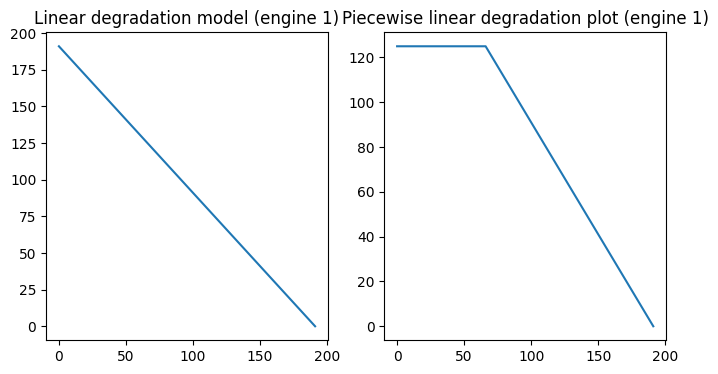

In [12]:
plt.figure(figsize = (8, 4))
plt.subplot(121)
plt.plot(engine_1_linear_degradation_model)
plt.title("Linear degradation model (engine 1)")
plt.subplot(122)
plt.plot(engine_1_piecewise_linear_degradation_model)
plt.title("Piecewise linear degradation plot (engine 1)")
plt.show()

Observe that while the linear degradation curve starts at 191 and ends at 0, piecewise linear degradation curve starts at 125, stays at 125 for some time and then linearly degrades to 0.

We can similarly find RUL values for other engines. But individually finding RUL for each engine is boring. So we will write a function that automatically finds RUL values for both models if it is supplied with the total number of cycles.

In [13]:
def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength (i.e., total number of cycles for each engine) and early_rul as input and 
    creates target rul.
    
    Arguments:
        data_length: (scaler) Number of cycles for each engine
        early_rul: (scaler) Early RUL value to be set. When set to `None`, linear degradation
                   curve is used. (deafult: None)

    Returns:
        target_array: (1D float array) Target array
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:    # This condition is needed when early rul is larger than data_length of an engine
            target_array = np.arange(data_length-1, -1, -1)
            return target_array
        else:
            target_array = np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))
            return target_array

Now for any engine, we can find RUL values for both models. For example, we will take engine 7. From above we find that engine 7 fails after 259 cycles. So its `data_length` is 259.

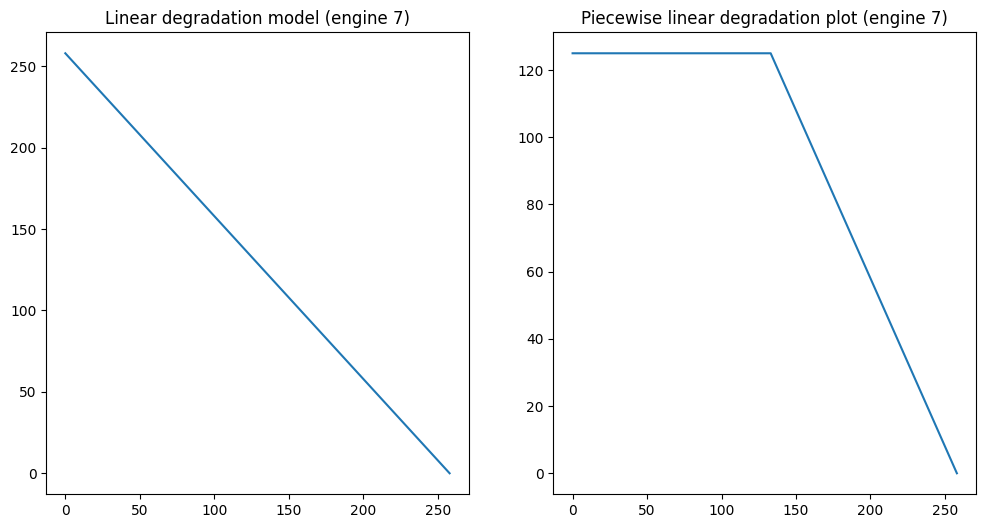

In [14]:
engine_7_linear_degradation_rul = process_targets(259, early_rul = None)
engine_7_piecewise_linear_degradation_rul = process_targets(259, early_rul = 125)
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.plot(engine_7_linear_degradation_rul)
plt.title("Linear degradation model (engine 7)")
plt.subplot(122)
plt.plot(engine_7_piecewise_linear_degradation_rul)
plt.title("Piecewise linear degradation plot (engine 7)")
plt.show()

## Analyzing Test data

Test data are similar to train data with only one difference. While for training data, data are available until failure for each engine, for test data, it is available for an arbitrary number of cycles. Using the given test data, out goal is to predict RUL. For test data, true RUL values are also available so that we can compare the performance of our prediction algorithm.

In [16]:
test_data = pd.read_csv("C://Users//dell//Documents//rul_codes_open//CMaps//test_FD001.txt", sep = "\s+", header = None)
test_data.shape

(13096, 26)

In [17]:
test_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


### How many engines are there in test set?

In [18]:
np.unique(test_data[0])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

So there are 100 engines in test set also.

### How many cycles of data are available for each engine in test set?

In [19]:
test_data.groupby(0)[1].count().values

array([ 31,  49, 126, 106,  98, 105, 160, 166,  55, 192,  83, 217, 195,
        46,  76, 113, 165, 133, 135, 184, 148,  39, 130, 186,  48,  76,
       140, 158, 171, 143, 196, 145,  50, 203, 198, 126, 121, 125,  37,
       133, 123, 156, 172,  54, 152, 146,  73,  78, 303,  74, 144, 189,
       164, 121, 113, 136, 160, 176,  94, 147, 159, 232, 155, 168,  71,
       147,  71, 187,  54, 152,  68, 131, 112, 137,  88, 205, 162,  72,
       101, 133, 213, 162,  73, 172,  34, 110,  56,  68, 177, 146, 234,
       150, 244, 133,  89,  97, 134, 121,  97, 198], dtype=int64)

We can see that data for 31 cycles are available for engine 1 in test set. Data for 49 cycles are available for engine 2, and so on. Using the available data our goal is to predict RUL for each engine.

In [20]:
true_rul = pd.read_csv('C://Users//dell//Documents//rul_codes_open//CMaps//RUL_FD001.txt', sep = '\s+', header = None)
true_rul[0].values

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20], dtype=int64)

An RUL value of 112 for engine 1 in test set means that it failed 112 cycles after 31st cycle. So engine 1 ran for (31+112) cycles before it failed. Similarly engine two failed 98 cycles after 49th cycle. So engine 2 ran for (49 + 98) cycles in total before it failed. Similar calculation can be done for other engines in test set.

For all our analysis, we will only use sensor measurements. First two columns of training data contain engine and cycle information respectively. So we don't need those columns while training an algorithm. Similarly columns 3-5 contain operational settings. We will also don't use those for training. It should be noted that some authors do use operational setting values to train their algorithm. But we will not do that. We will only use columns 6-26 values to train our algorithm as those are sensor measurements. But before we use those columns, we would first like to have some rough idea about the contents of the data. For that we will plot density plots of all sensor measurements of training data.

### Boxplot of sensor measurements (columns 6-26)

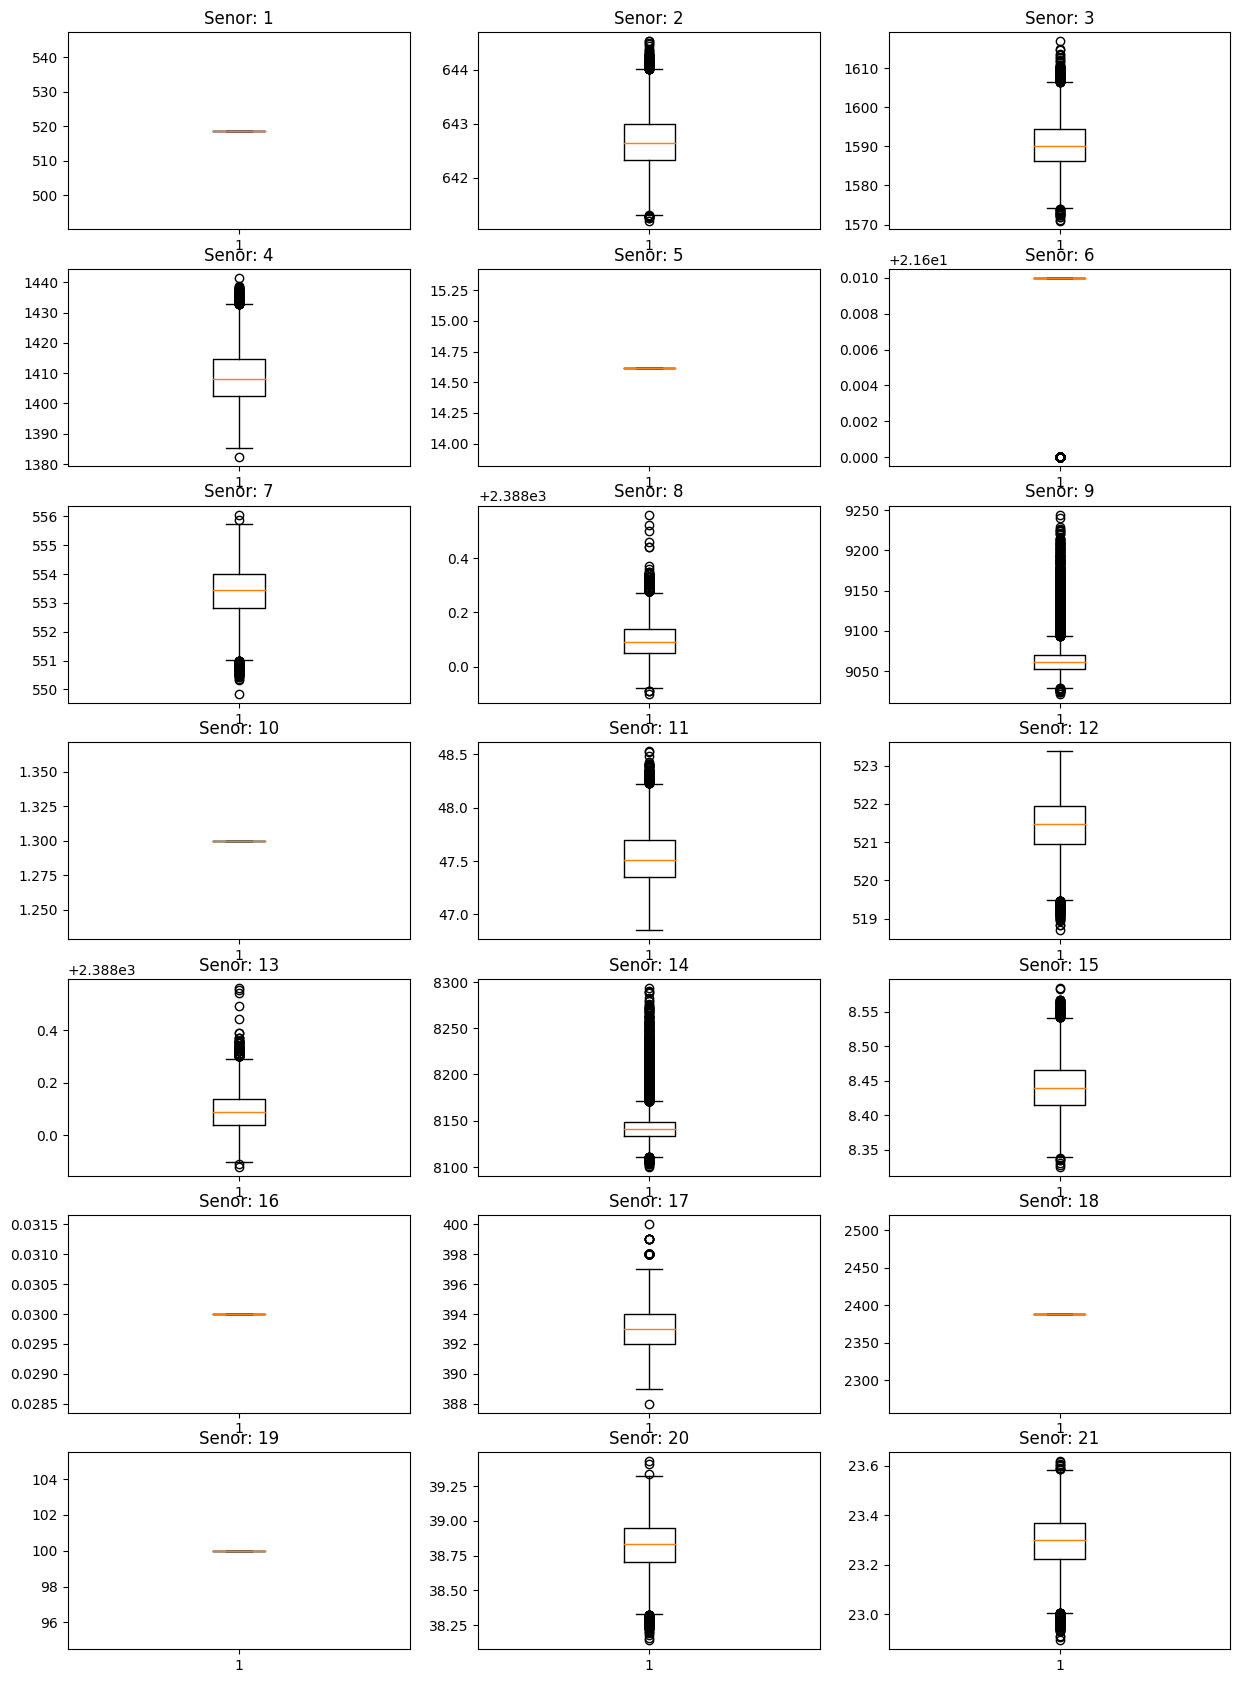

In [21]:
plt.figure(figsize = (15, 21))
for i in np.arange(5, 26):        # column 5 in python means actual 6th column
    temp = train_data.iloc[:, i]
    plt.subplot(7,3, i-4)
    plt.boxplot(temp)
    plt.title("Senor: "+ str(i-4))
plt.show()

From the above plot we see that columns 6, 10, 15, 21, 23, and 24 contain constant values. It also appears that Column 11 also contains only a few different values. We will check that.

In [22]:
train_data[10].value_counts()

21.61    20225
21.60      406
Name: 10, dtype: int64

So column 11 contains two constant values: 21.61 and 21.60. Frequency of 21.61 is 20225. As the values are close to each other, we can consider all the values to be constant. 

Constant values don't help us much while training an algorithm. Sometimes we also have to normalize data (subtract mean and divide by standard deviation). If a column contains a constant value, its standard deviation is zero. So normalization of that column is not possible as it requires division by zero. For these reasons, we will drop the columns containing constant values.

We can plot density plot of other columns as follows.

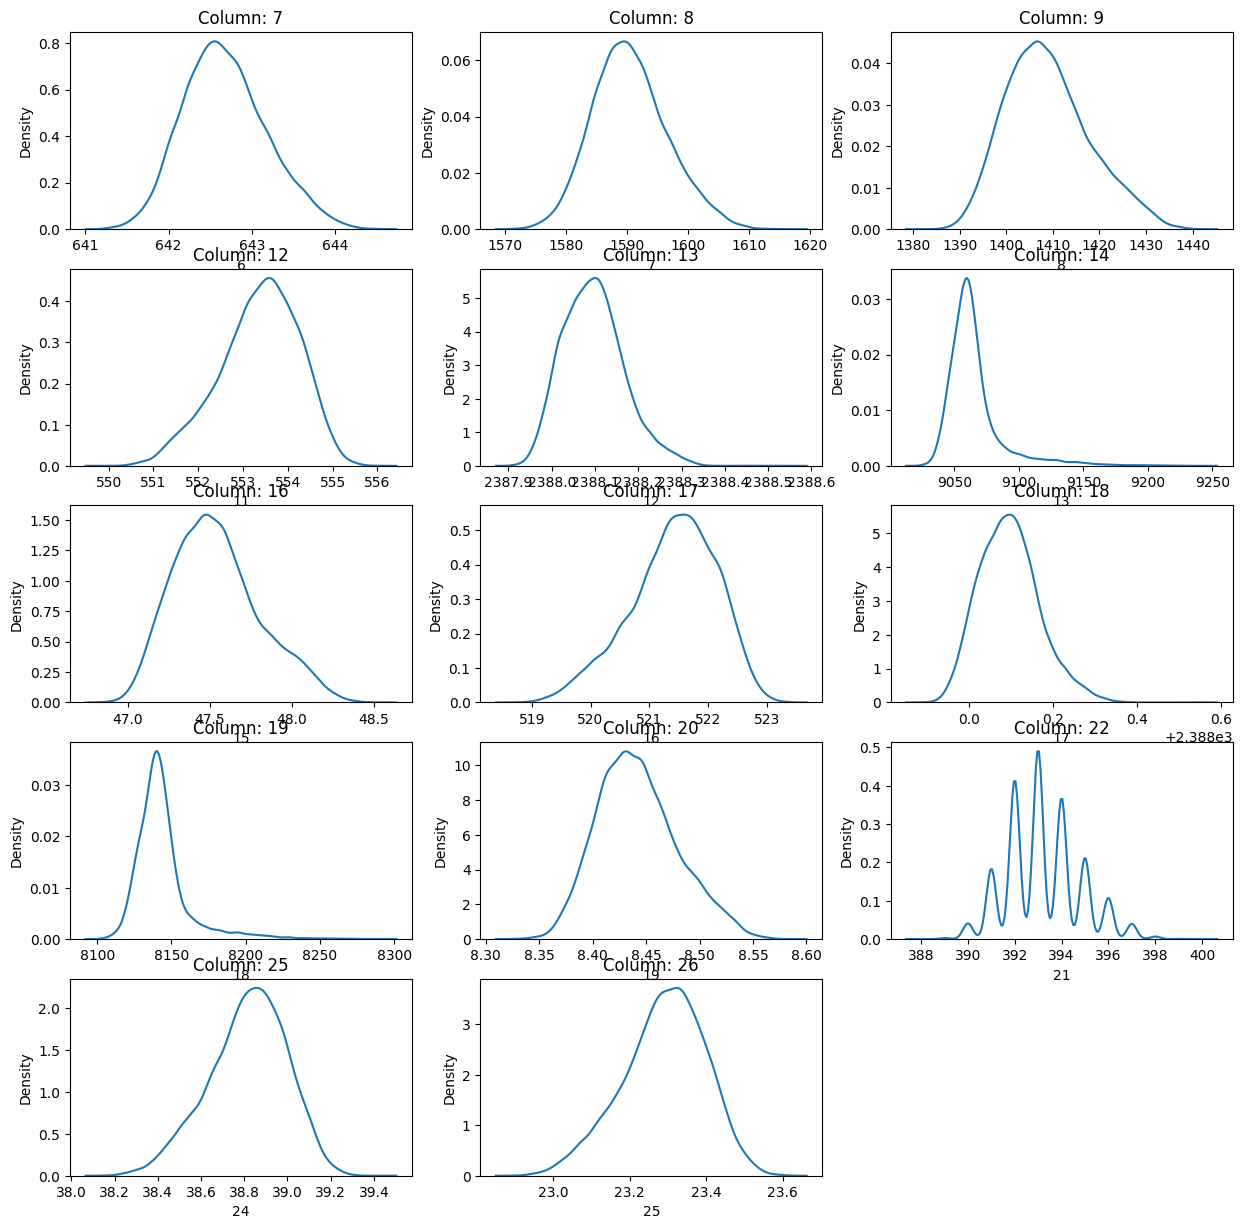

In [23]:
plt.figure(figsize = (15, 21))
for i,j in enumerate([6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 24, 25]):
    temp = train_data.iloc[:, j]
    plt.subplot(7,3, i+1)
    sns.kdeplot(temp, legend = False)
    plt.title("Column: "+ str(j+1))
plt.show()

An algorithm generalizes well (i.e., its performance on unseen data is good) if unseen data is similar in distribution to training data. Unseen data need not be exactly of same distribution as of training data but it should not be very different from training data.

Here, we will just check the distribution of training and test data. It should be noted that test data should never be used while training an algorithm. Training an algorithm is an iterative process. With more parameters, it is very likely that training error reduces nearly zero. But its performance on new unseen data is not that good. In that case, we say that the model has overfit the training data (or memorized the training examples). Therefore, while training we have to devise some way to check whether the model is learning something or just memorizing the training data. To do that, we extract a portion of training data as `validation set` and use the validation set to check performance of trained model at each iteration. Once we are satisfied with the final model, we can use it to evaluate its performance on test data. While iterating over different models, we should avoid overfitting the `validation data`.

Here, we will only show the density plot of training as well as test data.

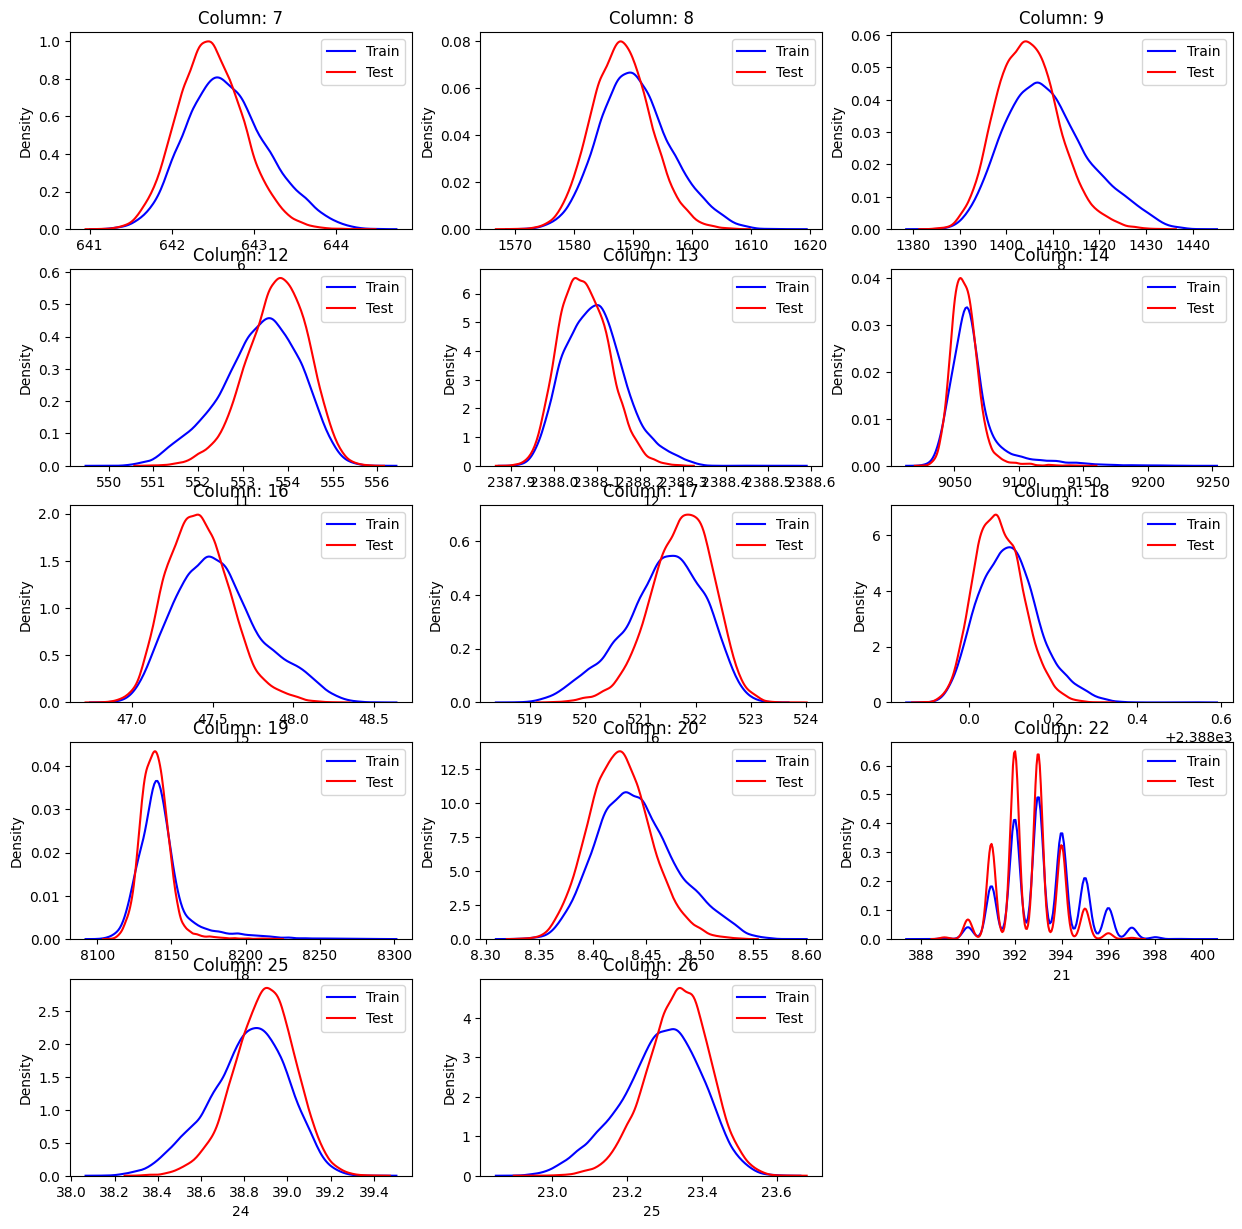

In [24]:
plt.figure(figsize = (15, 21))
for i,j in enumerate([6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 24, 25]):
    temp_train = train_data.iloc[:, j]
    temp_test = test_data.iloc[:, j]
    plt.subplot(7,3, i+1)
    sns.kdeplot(temp_train, legend = False, color = "blue", label = "Train")
    sns.kdeplot(temp_test, legend = False, color = "red", label = "Test")
    plt.title("Column: "+ str(j+1))
    plt.legend()
plt.show()

Though not exact, test data has a similar distribution as training data. So if we design our algorithm carefully, it will generalize well.

## Preparing data for training algorithm

While preparing data for a training algorithm, we have to consider several factors. Some of the factors are listed below.

* Should data be scaled?
* If data are scaled, should a single scaling be applied to all engines or individual scaling be applied for every engine?
* Should linear degradation model or piecewise linear degradation model for RUL be used?
* If piecewise linear degradation model is used, what is the value of early RUL?

To make things more concrete, we will specify the shapes of array. Our initial training data have a shape of $(20631 \times 26)$. We won't use engine info and operational settings for training. So after removing first 5 columns, our training data have a shape of $(20631 \times 21)$. From our previous data plotting, we found that 7 columns contain constant values. So we remove those columns. After removing those columns, our data have a shape of $(20631 \times 14)$. We choose to apply scaling individually to every engine.

For some applications, we consider each row of the data matrix as a data point and our training model is trained accordingly. But for some other applications, we use a window of data. For example, if window length is, say, 20, size of data for training would be $(20 \times 14)$. There may be overlap between windows. The following figure illustrates it for a toy dataset with 6 rows and 4 columns. 

![window preprocessing](data_windowing_prognosis.png)


Therefore, we will write a function, general enough, such that we can generate any type of data at a later stage depending upon our need. For that we need two custom functions: `process targets` and `process_input_data_with_targets`. We have already used the first function. Second function is defined as follows.

In [25]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """
    Depending on values of window_length and shift, this function generates batchs of data and targets 
    from `input_data` and `target_data`. `target_data` is optional. If no `target_data` is given, i.e., 
    `target_data = None`, no `output_targets` are generated. The following formula is used to determine
    number of batches. Please note that, here we use the term `batch` in a different sense than its usual
    meaning in deep learning.  
    
    Number of batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    
    **We don't check input dimensions using exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: (Must be 2D array) input data to function 
        target_data (optional): (Must be 1D array) Input rul values (default: None)
        window_length: (scalar) window length of data (default: 1)
        shift: (scalar) Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches (default: 1)
        
    Returns:
        output_data: (2D float array) Output data that would be passed to machine learning model
        output_targets (optional): (1D float array) Output targets. Only generated if `target_data` is
                                   passed as argument.
    """
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In the above function, we have used an argument `shift`. It is closely related to number of overlap rows. For example, if window length is 30 and shift is 2, it would mean there is an overlap of 28 rows between successive data batches. 

## Check whether the functions works as intended or not

In [20]:
data = np.array([[1,2,3,4,5],
                 [6,7,8,9,10],
                 [11,12,13,14,15],
                 [16,17,18,19,20],
                 [21,22,23,24,25],
                 [26,27,28,29,30]])
ruls = np.array([31,32,33,34,35,36])
print("Data:")
print(data)
print()
print("RUL:")
print(ruls)

Data:
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]
 [21 22 23 24 25]
 [26 27 28 29 30]]

RUL:
[31 32 33 34 35 36]


In [21]:
check_data, check_rul = process_input_data_with_targets(data,target_data = ruls, window_length = 3, shift = 1)
print(check_data)
print()
print(check_rul)

[[[ 1.  2.  3.  4.  5.]
  [ 6.  7.  8.  9. 10.]
  [11. 12. 13. 14. 15.]]

 [[ 6.  7.  8.  9. 10.]
  [11. 12. 13. 14. 15.]
  [16. 17. 18. 19. 20.]]

 [[11. 12. 13. 14. 15.]
  [16. 17. 18. 19. 20.]
  [21. 22. 23. 24. 25.]]

 [[16. 17. 18. 19. 20.]
  [21. 22. 23. 24. 25.]
  [26. 27. 28. 29. 30.]]]

[33. 34. 35. 36.]


In [22]:
check_data_2, check_rul_2 = process_input_data_with_targets(data,target_data = ruls, window_length = 3, shift = 2)
print(check_data_2)
print()
print(check_rul_2)

[[[ 1.  2.  3.  4.  5.]
  [ 6.  7.  8.  9. 10.]
  [11. 12. 13. 14. 15.]]

 [[11. 12. 13. 14. 15.]
  [16. 17. 18. 19. 20.]
  [21. 22. 23. 24. 25.]]]

[33. 35.]


Note that in our function, `target_data` argument is optional. If we don't pass any data in that argument, we get only batched data as output. This is useful for preprocessing test data for which we don't know target RUL values. The following cell illustrates this with an example.

In [23]:
check_data_new = process_input_data_with_targets(data, target_data = None, window_length = 4, shift = 1)
check_data_new

array([[[ 1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10.],
        [11., 12., 13., 14., 15.],
        [16., 17., 18., 19., 20.]],

       [[ 6.,  7.,  8.,  9., 10.],
        [11., 12., 13., 14., 15.],
        [16., 17., 18., 19., 20.],
        [21., 22., 23., 24., 25.]],

       [[11., 12., 13., 14., 15.],
        [16., 17., 18., 19., 20.],
        [21., 22., 23., 24., 25.],
        [26., 27., 28., 29., 30.]]])

Now we are ready to use the functions to preprocess the actual CMAPSS data. For this demonstration, we will use following function argument values.

* window_length = 30
* shift = 1 (It is equivalent to overlap of 29 rows between successive windowed data)
* early_rul = 125

We have also used

* MinMaxScaling with feature range (-1, 1). We can change this to StandardScaler if we want. Scaling is applied individually to each engine of training set. The scaling parameters learned from training data is then used to scale test data of corresponding engine. 

### How to preprocess test data?

For each engine in the test set, we need to predict one RUL value. To predict one RUL value, we need one example of test data for each engine. So the obvious choice is to use the last example of test data for each engine. If an example consists of a window of data, for a given window length, we will take the last window of data that can be extracted from test set for a particular engine. For example, assume that for a particular engine, test set data has a shape of $(45 \times 14)$. For `window_length = 30`, and `shift = 1`, we can extract 16 windowed datasets of size $(30 \times 14)$. But we have to predict only one number as RUL for that engine. So, out of the 13 datasets of size $(30 \times 14)$, we will use the last one for predicting RUL. 

The above approach, though technically correct, is prone to mistakes. What happens if the measurements of last example have some outliers? In that case our prediction would be way off. One approach to circumvent this issue is to take, say, last 5 examples instead of only the last example for each engine. Then we will get 5 RUL prediction values. We can average those to come up with our final estimate of RUL. In this way our RUL estimate will be a little conservative but robust against outliers in the last test example. 

In the following cell, we will write a function that prepares a number of test examples as per user input. 

In [24]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ 
    This function takes test data for an engine as first input. The next two inputs,
    window_length and shift are same as other functions. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examples we
    want from test data (from last). By default it extracts only the last example.
    
    The function returns last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler helps us do just that.

    Arguments:
        test_data_for_an_engine: (2D array) input test data
        window_length: (scalar) window length of data
        shift: (scalar) Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        num_test_windows: (scalar) Number of examples to take from last. (default: 1)

    Returns:
        batched_test_data_for_an_engine: (2D array) Batched test data. Please note that, here we have used the term `batch`
                                         in a different sense than its usual meaning in deep learning.
        extracted_num_test_windows: (scalar) Extracted number of test examples from last. If `num_test_windows` number of
                                    examples can't be extracted from test data, in that case `extracted_num_test_windows`
                                    is less than `num_test_windows`. 
    """
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        extracted_num_test_windows = max_num_test_batches
        return batched_test_data_for_an_engine, extracted_num_test_windows
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        extracted_num_test_windows = num_test_windows
        return batched_test_data_for_an_engine, extracted_num_test_windows

Now we will check whether the above function works as intended or not.

In [25]:
check_data = np.reshape(np.arange(24), newshape = (6,4))
check_data

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19],
       [20, 21, 22, 23]])

In [26]:
last_examples, num_last_examples = process_test_data(check_data, window_length = 2, shift = 1, num_test_windows= 1)
print(last_examples)
print()
print(num_last_examples)

[[[16. 17. 18. 19.]
  [20. 21. 22. 23.]]]

1


Now change `num_test_window` to 3. This will extract last 3 examples.

In [27]:
last_examples, num_last_examples = process_test_data(check_data, window_length = 2, shift = 1, num_test_windows= 3)
print(last_examples)
print()
print(num_last_examples)

[[[ 8.  9. 10. 11.]
  [12. 13. 14. 15.]]

 [[12. 13. 14. 15.]
  [16. 17. 18. 19.]]

 [[16. 17. 18. 19.]
  [20. 21. 22. 23.]]]

3


If we set `window_length = 1`, and `num_test_windows = 3`, we will simply select last 3 rows of test data. For the above toy data, we get the following result. 

In [28]:
last_examples, num_last_examples = process_test_data(check_data, window_length = 1, shift = 1, num_test_windows= 3)
print(last_examples)
print()
print(num_last_examples)

[[[12. 13. 14. 15.]]

 [[16. 17. 18. 19.]]

 [[20. 21. 22. 23.]]]

3


### How to scale data?

For some algorithms, it is required to scale the data first before feeding it into the algorithm. We can use built-in scikit-learn scalers like `StandardScaler`, `MinMaxScaler`, etc. We will first scale the training data individually for each engine. Using the scaled parameters, we will then scale the data for corresponding test engine. For example, FD001 contains training data for 100 engines. So we will individually scale training data for 100 engines. Test data for FD001 also contains 100 engines. We will use scaling parameters of training data to scale corresponding engine data in test set.

When there is a discrepancy in number of engines between training and test set (this occurs in FD002 and FD004), we scale only those training data for which there is a corresponding engine in test set. Again to give a concrete example, FD004 contains 249 training engines but 248 test engines. So while scaling data for this case, we ignore data corresponding to engine 249 in training set as there is no corresponding data in test set.

In the following cell, scaling is performed using 3 lines of code. If for some application scaling is not required, then just comment those 3 lines.

In the following cell, we will preprocess both training and test data with scaling.

In [29]:
window_length = 30
shift = 1
early_rul = 125             # Set to None for linear degradation model
processed_train_data = []
processed_train_targets = []

# How many test examples to take for each engine. If set to 1 (this is the default), only last example of test data for 
# each engine are taken. If set to a different number, that many examples from last are taken. 
# Final output for an engine will be the average of output of all examples for that engine.
num_test_windows = 1     # Number of examples. Change to a different number to select that many test examples for each engine.
processed_test_data = []
num_test_windows_list = []  # This list keeps track of number of examples for all engines in the test set.

num_machines = np.min([len(train_data[0].unique()), len(test_data[0].unique())])

for i in np.arange(1, num_machines + 1):
    
    temp_train_data = train_data[train_data[0] == i].drop(columns=[0,1,2,3,4,5,9,10,14,20,22,23]).values
    temp_test_data = test_data[test_data[0] == i].drop(columns=[0,1,2,3,4,5,9,10,14,20,22,23]).values
    
    # Verify if data of given window length can be extracted from both training and test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    elif (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # We have used MinMaxScaler. Use a different scaler if you want.
    # Or just comment the following 3 lines if no scaling is required.
    scaler = MinMaxScaler(feature_range = (-1, 1))
    temp_train_data = scaler.fit_transform(temp_train_data)
    temp_test_data = scaler.transform(temp_test_data)    
    
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)
processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

In [30]:
print(processed_train_data.shape)
print(processed_train_targets.shape)
print(processed_test_data.shape)
print(true_rul.shape)

(17731, 30, 14)
(17731,)
(100, 30, 14)
(100,)


### How to scale the whole dataset?

In the previous cells, we showed the procedure to scale data enginewise. But for some applications, we may need to scale the full training and test dataset. This can be achieved as follows. In the cell below, we will use `StandardScaling` to scale the full training and test set.

In [31]:
train_data = pd.read_csv("/home/biswajit/data/cmapss_data/train_FD001.txt", sep= "\s+", header = None)
test_data = pd.read_csv("/home/biswajit/data/cmapss_data/test_FD001.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("/home/biswajit/data/cmapss_data/RUL_FD001.txt", sep = '\s+', header = None)

window_length = 30
shift = 1
early_rul = 125            
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 1     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data separately as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process training data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed training data shape: ", processed_train_data.shape)
print("Processed training rul shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed training data shape:  (17731, 30, 14)
Processed training rul shape:  (17731,)
Processed test data shape:  (100, 30, 14)
True RUL shape:  (100,)


Now we can use our favorite algorithm to train the model. If we want to change shape of training data, we can change `window_length`, and `shift` to get desired shape of input data. Similarly we can either use linear degradation model of RUL (by setting `early_rul = Null`) or use piecewise linear degradation model by using a suitable value of `early_rul`. If we to scale data differently, we can use a different scaler in place of `MinMaxScaler` or `StandardScaler`. 

In other notebooks, we will only use the functions to preprocess data and then apply the algorithm. Other notebooks applying different techniques for RUL prediction can be found [here](https://biswajitsahoo1111.github.io/rul_codes_open/). 